In [10]:
pip install --upgrade metpy

     |████████████████████████████████| 319 kB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 720 kB 36.3 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 947 kB/s s eta 0:00:01
     |████████████████████████████████| 205 kB 66.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install netcdf4

     |████████████████████████████████| 4.3 MB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 287 kB 106.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Initialize notebook environment.
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import os.path
import xarray as xr

In [2]:
era5_bucket = 'era5-pds'

# AWS access / secret keys required
# s3 = boto3.resource('s3')
# bucket = s3.Bucket(era5_bucket)

# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

In [3]:
paginator = client.get_paginator('list_objects')
result = paginator.paginate(Bucket=era5_bucket, Delimiter='/')
for prefix in result.search('CommonPrefixes'):
    print(prefix.get('Prefix'))

1979/
1980/
1981/
1982/
1983/
1984/
1985/
1986/
1987/
1988/
1989/
1990/
1991/
1992/
1993/
1994/
1995/
1996/
1997/
1998/
1999/
2000/
2001/
2002/
2003/
2004/
2005/
2006/
2007/
2008/
2009/
2010/
2011/
2012/
2013/
2014/
2015/
2016/
2017/
2018/
2019/
2020/
QA/
zarr/


In [22]:
keys = []
date = datetime.date(2018,1,31) # update to desired date
prefix = date.strftime('%Y/%m/')

response = client.list_objects_v2(Bucket=era5_bucket, Prefix=prefix)
response_meta = response.get('ResponseMetadata')

if response_meta.get('HTTPStatusCode') == 200:
    contents = response.get('Contents')
    if contents == None:
        print("No objects are available for %s" % date.strftime('%B, %Y'))
    else:
        for obj in contents:
            keys.append(obj.get('Key'))
        print("There are %s objects available for %s\n--" % (len(keys), date.strftime('%B, %Y')))
        for k in keys:
            print(k)
else:
    print("There was an error with your request.")

There are 20 objects available for January, 2018
--
2018/01/data/air_pressure_at_mean_sea_level.nc
2018/01/data/air_temperature_at_2_metres.nc
2018/01/data/air_temperature_at_2_metres_1hour_Maximum.nc
2018/01/data/air_temperature_at_2_metres_1hour_Minimum.nc
2018/01/data/dew_point_temperature_at_2_metres.nc
2018/01/data/eastward_wind_at_100_metres.nc
2018/01/data/eastward_wind_at_10_metres.nc
2018/01/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc
2018/01/data/lwe_thickness_of_surface_snow_amount.nc
2018/01/data/northward_wind_at_100_metres.nc
2018/01/data/northward_wind_at_10_metres.nc
2018/01/data/precipitation_amount_1hour_Accumulation.nc
2018/01/data/sea_surface_temperature.nc
2018/01/data/sea_surface_wave_from_direction.nc
2018/01/data/sea_surface_wave_mean_period.nc
2018/01/data/sea_surface_wind_wave_from_direction.nc
2018/01/data/significant_height_of_wind_and_swell_waves.nc
2018/01/data/snow_density.nc
2018/01/data/surface_air_pr

In [4]:
# select date and variable of interest
j=0
for i in range(1996,2021):
    for j in range(1,13):
        date = datetime.date(i,j,1)
        var = 'air_temperature_at_2_metres'
        # file path patterns for remote S3 objects and corresponding local file
        s3_data_ptrn = '{year}/{month}/data/{var}.nc'
        data_file_ptrn = '{year}{month}_{var}.nc'
        year = date.strftime('%Y')
        month = date.strftime('%m')
        s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
        data_file = data_file_ptrn.format(year=year, month=month, var=var)
        if not os.path.isfile(data_file): # check if file already exists
            print("Downloading %s from S3..." % s3_data_key)
            client.download_file(era5_bucket, s3_data_key, data_file)    

KeyboardInterrupt: 

In [24]:
# location coordinates
locs = [
    {'name': 'santa_monica', 'lon': -118.496245, 'lat': 34.010341},
    {'name': 'tallinn', 'lon': 24.753574, 'lat': 59.436962},
    {'name': 'honolulu', 'lon': -157.835938, 'lat': 21.290014},
    {'name': 'cape_town', 'lon': 18.423300, 'lat': -33.918861},
    {'name': 'dubai', 'lon': 55.316666, 'lat': 25.266666},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'santa_monica', 'lon': 241.503755, 'lat': 34.010341},
 {'name': 'tallinn', 'lon': 24.753574, 'lat': 59.436962},
 {'name': 'honolulu', 'lon': 202.164062, 'lat': 21.290014},
 {'name': 'cape_town', 'lon': 18.4233, 'lat': -33.918861},
 {'name': 'dubai', 'lon': 55.316666, 'lat': 25.266666}]

In [25]:
import pandas as pd
ds_locs = xr.Dataset()
df_new = pd.DataFrame()
def kelvin_to_celcius(t):
    return t - 273.15
for i in range(1995,2019):
    for j in range(1,13):
        date = datetime.date(i,j,1)
        var = 'air_temperature_at_2_metres'
        # file path patterns for remote S3 objects and corresponding local file
        s3_data_ptrn = '{year}/{month}/data/{var}.nc'
        data_file_ptrn = '{year}{month}_{var}.nc'
        year = date.strftime('%Y')
        month = date.strftime('%m')
        data_file = data_file_ptrn.format(year=year, month=month, var=var)
        ds = xr.open_dataset(data_file)
        for l in locs:
            name = l['name']
            lon = l['lon']
            lat = l['lat']
            var_name = name

            ds2 = ds.sel(lon=lon, lat=lat, method='nearest')

            lon_attr = '%s_lon' % name
            lat_attr = '%s_lat' % name

            ds2.attrs[lon_attr] = ds2.lon.values.tolist()
            ds2.attrs[lat_attr] = ds2.lat.values.tolist()
            ds2 = ds2.rename({var : var_name}).drop(('lat', 'lon'))
    
            ds_locs = xr.merge([ds_locs, ds2])
        ds_locs_f = ds_locs.apply(kelvin_to_celcius)
        df_f = ds_locs_f.to_dataframe()
        df_new = pd.concat([df_new,df_f])

In [26]:
df_new

,santa_monica,tallinn,honolulu,cape_town,dubai
time0,,,,,
1995-01-01 00:00:00,13.225006,2.350006,22.537506,16.537506,15.162506
1995-01-01 01:00:00,12.850006,2.225006,22.600006,16.537506,14.725006
1995-01-01 02:00:00,12.412506,2.162506,22.537506,16.162506,14.475006
1995-01-01 03:00:00,11.287506,2.037506,22.225006,16.600006,14.725006
1995-01-01 04:00:00,11.287506,1.912506,22.100006,16.412506,14.662506
...,...,...,...,...,...
2018-12-31 19:00:00,15.287506,-0.024994,23.975006,20.475006,21.350006
2018-12-31 20:00:00,16.100006,0.287506,24.225006,19.912506,20.537506
2018-12-31 21:00:00,16.975006,0.537506,24.287506,19.850006,20.037506


In [ ]:
df_new.drop_duplicates(inplace=True)

In [27]:
df_new.to_csv('big_data.csv',index=True)

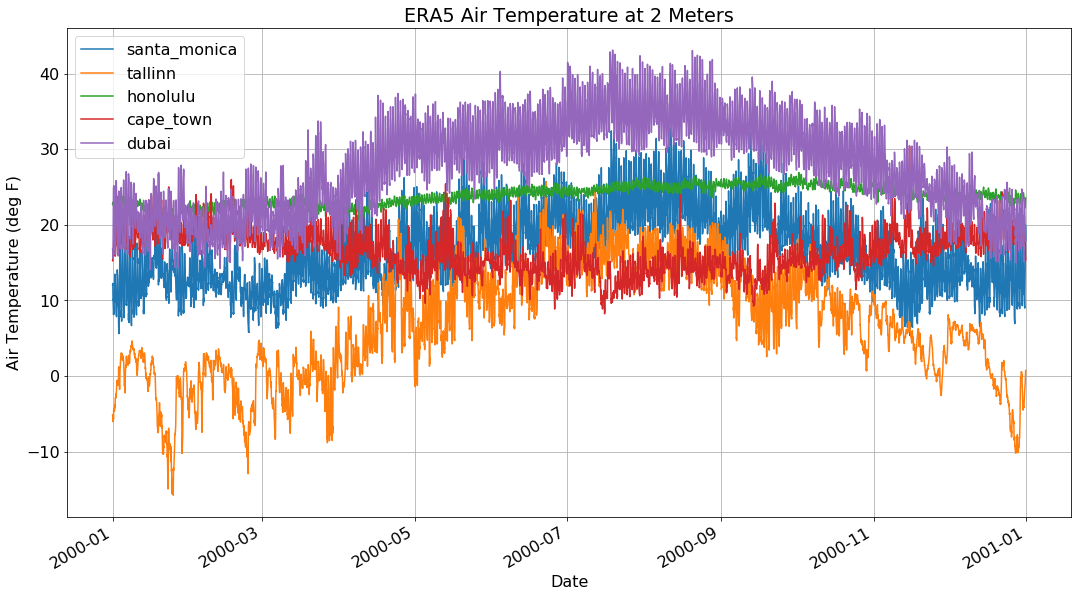

In [14]:
# readability please
plt.rcParams.update({'font.size': 16})

ax = df_new.plot(figsize=(18, 10), title="ERA5 Air Temperature at 2 Meters", grid=1)
ax.set(xlabel='Date', ylabel='Air Temperature (deg F)')
plt.show()


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('big_data.csv')

In [3]:
df

,time0,santa_monica,tallinn,honolulu,cape_town,dubai
0,1995-01-01 00:00:00,13.225006,2.350006,22.537506,16.537506,15.162506
1,1995-01-01 01:00:00,12.850006,2.225006,22.600006,16.537506,14.725006
2,1995-01-01 02:00:00,12.412506,2.162506,22.537506,16.162506,14.475006
3,1995-01-01 03:00:00,11.287506,2.037506,22.225006,16.600006,14.725006
4,1995-01-01 04:00:00,11.287506,1.912506,22.100006,16.412506,14.662506
...,...,...,...,...,...,...
30396523,2018-12-31 19:00:00,15.287506,-0.024994,23.975006,20.475006,21.350006
30396524,2018-12-31 20:00:00,16.100006,0.287506,24.225006,19.912506,20.537506
30396525,2018-12-31 21:00:00,16.975006,0.537506,24.287506,19.850006,20.037506
30396526,2018-12-31 22:00:00,16.412506,0.600006,24.537506,19.287506,19.537506


In [6]:
df_new = df.iloc[:,[0,1]]

In [7]:
df_new

,time0,santa_monica
0,1995-01-01 00:00:00,13.225006
1,1995-01-01 01:00:00,12.850006
2,1995-01-01 02:00:00,12.412506
3,1995-01-01 03:00:00,11.287506
4,1995-01-01 04:00:00,11.287506
...,...,...
30396523,2018-12-31 19:00:00,15.287506
30396524,2018-12-31 20:00:00,16.100006
30396525,2018-12-31 21:00:00,16.975006
30396526,2018-12-31 22:00:00,16.412506


In [8]:
df_new.dtypes

time0            object
santa_monica    float64
dtype: object

In [9]:
df_new['time0'] = pd.to_datetime(df_new['time0'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [10]:
df_new.dtypes

time0           datetime64[ns]
santa_monica           float64
dtype: object

In [11]:
outputList = []
for row in df_new.iterrows():
    df_month = row[1][0].month
    df_day = int(row[1][0].day)
    df_hour = int(row[1][0].hour)
    df_year = int(row[1][0].year)
    df_temp = row[1][1]
    outputList.append({"Month":df_month, "Day":df_day, "Hour":df_hour, "Year":df_year, "Temp":df_temp})
df_new_2 = pd.DataFrame(outputList)    

In [12]:
df_new_2.sort_values(by=['Month', 'Day', 'Hour', 'Year'],inplace=True)

In [53]:
index_names = df_new_2[(df_new_2['Month']==2) & (df_new_2['Day']==29)].index

In [54]:
index_names

Int64Index([ 10176,  45240,  80304, 115368, 150432, 185496,  10177,  45241,
             80305, 115369,
            ...
             80326, 115390, 150454, 185518,  10199,  45263,  80327, 115391,
            150455, 185519],
           dtype='int64', length=144)

In [55]:
df_new_2.drop(index_names, inplace = True) 

In [60]:
outputList = []
dict_year_temp = dict()
count=0
dict_month = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',
           11:'November',12:'December'}
for row in df_new_2.iterrows():
    count+=1
    if(count==1):
        df_month = int(row[1][0])
        df_month_name = dict_month[df_month]
        df_day = int(row[1][1])
        df_hour = int(row[1][2])
        df_year = int(row[1][3])
        df_temp = row[1][4]
        dict_year_temp[df_year] = df_temp
    else:
        df_year = int(row[1][3])
        df_temp = row[1][4]
        dict_year_temp[df_year] = df_temp
    if(count==24):
        outputList.append({"Month":df_month_name, "Day":df_day, "Hour":df_hour, 1995:dict_year_temp[1995], 1996:dict_year_temp[1996],
                          1997:dict_year_temp[1997], 1998:dict_year_temp[1998], 1999:dict_year_temp[1999],2000:dict_year_temp[2000],
                          2001:dict_year_temp[2001],2002:dict_year_temp[2002],2003:dict_year_temp[2003],2004:dict_year_temp[2004],
                          2005:dict_year_temp[2005],2006:dict_year_temp[2006],2007:dict_year_temp[2007], 2008:dict_year_temp[2008],
                          2009:dict_year_temp[2009], 2010:dict_year_temp[2010], 2011:dict_year_temp[2011], 2012:dict_year_temp[2012],
                          2013:dict_year_temp[2013], 2014:dict_year_temp[2014], 2015:dict_year_temp[2015], 2016:dict_year_temp[2016],
                          2017:dict_year_temp[2017], 2018:dict_year_temp[2018]})
        count = 0
df_new_3 = pd.DataFrame(outputList) 

In [61]:
df_new_3

,Month,Day,Hour,1995,1996,1997,1998,1999,2000,2001,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,January,1,0,13.225006,18.162506,15.475006,19.350006,15.225006,12.019012,17.600006,...,14.475006,16.725006,11.350006,19.850006,12.600006,18.225006,12.162506,16.662506,11.350006,17.162506
1,January,1,1,12.850006,17.350006,15.725006,18.600006,14.475006,12.048553,16.475006,...,13.725006,15.912506,11.412506,18.787506,11.600006,16.412506,11.600006,15.287506,10.975006,16.037506
2,January,1,2,12.412506,16.725006,15.725006,17.912506,14.850006,12.234039,17.412506,...,13.787506,14.287506,9.412506,15.912506,10.975006,14.975006,10.412506,13.787506,10.600006,14.850006
3,January,1,3,11.287506,15.037506,14.225006,15.412506,11.975006,10.198364,12.975006,...,12.412506,12.162506,7.975006,14.225006,10.287506,14.162506,8.850006,12.225006,9.600006,13.912506
4,January,1,4,11.287506,14.787506,13.787506,15.662506,11.850006,10.057220,12.975006,...,11.100006,11.350006,7.600006,14.225006,8.975006,12.725006,7.725006,11.537506,9.287506,13.225006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,December,31,19,16.287506,13.975006,17.725006,14.100006,11.100006,15.600006,13.350006,...,14.787506,9.662506,18.100006,11.600006,17.537506,10.537506,14.662506,12.912506,16.037506,15.287506
8756,December,31,20,17.350006,14.037506,18.162506,14.287506,11.475006,16.350006,13.537506,...,15.912506,10.162506,20.037506,12.600006,18.787506,11.225006,15.975006,12.725006,17.100006,16.100006
8757,December,31,21,19.975006,14.162506,20.350006,17.662506,12.725006,19.975006,15.662506,...,17.662506,11.225006,21.037506,13.662506,19.662506,11.850006,17.037506,12.100006,17.662506,16.975006
8758,December,31,22,18.475006,16.037506,20.412506,15.725006,12.225006,18.037506,13.850006,...,17.600006,11.350006,22.350006,13.225006,19.225006,12.475006,17.225006,12.100006,17.600006,16.412506


In [62]:
df_new

,time0,santa_monica
0,1995-01-01 00:00:00,13.225006
1,1995-01-01 01:00:00,12.850006
2,1995-01-01 02:00:00,12.412506
3,1995-01-01 03:00:00,11.287506
4,1995-01-01 04:00:00,11.287506
...,...,...
30396523,2018-12-31 19:00:00,15.287506
30396524,2018-12-31 20:00:00,16.100006
30396525,2018-12-31 21:00:00,16.975006
30396526,2018-12-31 22:00:00,16.412506


In [63]:
df_new.to_csv('big_data_compare.csv',index=False)
df_new_3.to_csv('big_data_new.csv',index=False)